# Анализ гипотез для увеличения выручки интернет-магазина. А/В-тестирование

В данной работе, как аналитику интернет-магазина, нам предстоит **проанализировать подготовленные с отделом маркетинга гипотезы для увеличения выручки, приоритизировать их и запустить А/В-тест.**

В нашем распоряжении есть 3 датафрейма с данными о гипотезах, о заказах и пользователях интернет-магазина.

В первую очередь необходимо провести предобработку данных, подготовить их для дальнейшей аналитической работы с ними. Далее проанализируем имеющиеся гипотезы, приоритизируем их с помощью методов `ICE` и `RICE` и посмотрим на различия в результатах.
И, наконец, запустим А/В-тест, по результатам которого проанализируем изменение показателей, а также ответим на вопрос, есть ли различия между представленными группами.

**План работы:**

1. [Загрузка и предобработка данных](#Загрузка-и-предобработка-данных)
    1. [Загрузка данных](#Загрузка-данных)
    2. [Предобработка данных](#Предобработка-данных)
2. [Приоритизация гипотез](#Приоритизация-гипотез)
    1. [Применение фреймворка ICE для приоритизации гипотез](#Применение-фреймворка-ICE-для-приоритизации-гипотез)
    2. [Применение фреймворка RICE для приоритизации гипотез](#Применение-фреймворка-RICE-для-приоритизации-гипотез)
    3. [Вывод](#Вывод)
3. [Анализ A/B-теста](#Анализ-A/B-теста)
    1. [График кумулятивной выручки по группам](#График-кумулятивной-выручки-по-группам)
    2. [График кумулятивного среднего чека по группам](#График-кумулятивного-среднего-чека-по-группам)
    3. [График относительного изменения кумулятивного среднего чека группы B к группе A](#График-относительного-изменения-кумулятивного-среднего-чека-группы-B-к-группе-A)
    4. [График кумулятивного среднего количества заказов на посетителя по группам](#График-кумулятивного-среднего-количества-заказов-на-посетителя-по-группам)
    5. [График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A](#График-относительного-изменения-кумулятивного-среднего-количества-заказов-на-посетителя-группы-B-к-группе-A)
    6. [Точечный график количества заказов по пользователям](#Точечный-график-количества-заказов-по-пользователям)
    7. [95-й и 99-й перцентили количества заказов на пользователя](#95-й-и-99-й-перцентили-количества-заказов-на-пользователя)
    8. [Точечный график стоимостей заказов](#Точечный-график-стоимостей-заказов)
    9. [95-й и 99-й перцентили стоимости заказов](#95-й-и-99-й-перцентили-стоимости-заказов)
    10. [Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным](#Статистическая-значимость-различий-в-среднем-количестве-заказов-на-посетителя-между-группами-по-«сырым»-данным)
    11. [Статистическя значимость различий в среднем чеке заказа между группами по «сырым» данным](#Статистическя-значимость-различий-в-среднем-чеке-заказа-между-группами-по-«сырым»-данным)
    12. [Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным](#Статистическая-значимость-различий-в-среднем-количестве-заказов-на-посетителя-между-группами-по-«очищенным»-данным)
    13. [Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#Статистическая-значимость-различий-в-среднем-чеке-заказа-между-группами-по-«очищенным»-данным)
4. [Вывод](#Вывод)

**Описание данных:**

`hypothesis`:
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

`orders`:
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

`visitors`:
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка и предобработка данных

### Загрузка данных

In [1]:
# Импортируем библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
hypothesis = pd.read_csv(r'C:\Users\ivank\practicum\datasets\hypothesis.csv')

hypothesis.columns = hypothesis.columns.str.lower()
pd.set_option('display.max_colwidth', False)
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

В таблице с гипотезами привели названия столбцов к нижнему регистру.

Изучим информацию о датафреймах `orders` и `visitors`.

In [3]:
orders = pd.read_csv(r'C:\Users\ivank\practicum\datasets\orders_ab.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

In [4]:
orders.info()

print('Количество дубликатов:', orders.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
Количество дубликатов: 0


In [5]:
visitors = pd.read_csv(r'C:\Users\ivank\practicum\datasets\visitors_ab.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [6]:
visitors.info()

print('Количество дубликатов:', visitors.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
Количество дубликатов: 0


Библиотеки и датасеты были загружены, приступим к предобработке.

### Предобработка данных

В таблицах нет пропусков и строк-дубликатов, однако в обоих датафреймах выбран неверный тип даты, необходимо его изменить.

In [7]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Изучим более подробную информацию о тесте, сколько он длился, сколько человек в нем учавствовало.

In [8]:
print('Дата начала теста:', orders['date'].min())
print('Дата окончания теста:', orders['date'].max())
print('Количество групп, учавствовавших в тесте:', orders['group'].nunique())
print('Общее количество человек в группах:', orders['visitorId'].nunique())
print('Количество человек в группе А:', orders.query('group == "A"')['visitorId'].nunique())
print('Количество человек в группе В:', orders.query('group == "B"')['visitorId'].nunique())

Дата начала теста: 2019-08-01 00:00:00
Дата окончания теста: 2019-08-31 00:00:00
Количество групп, учавствовавших в тесте: 2
Общее количество человек в группах: 1031
Количество человек в группе А: 503
Количество человек в группе В: 586


Тест длился в течение всего месяца мая 2019 года. Общее количество человек, принявших участие в тесте, равно 1031, однако учитывая, что в группах 503 и 586 человек, можно сделать вывод о том, что некоторое количество пользователей пересекается в обеих группах. Поскольку мы не сможем удалить данные с этими пользователями из таблицы visitors, просто посчитаем количество этих пользователей и будем иметь в виду.

In [9]:
orders.groupby('visitorId').agg({'group':'nunique'}).query('group>1').count()

group    58
dtype: int64

Итак, данные были проверены на дубликаты и пропуски, которых обнаружено не было. В первой таблице названия столбцов были приведены к нижнему регистру, в остальных таблицах в названиях нет недочетов. Также сталбцы с датами были приведены к правильному типу данных. 

Тест проходил в течение месяца, всего в нем учавствовало 1031 человек, 58 из которых участвовали в обеих группах.

На данном этапе предобрабоку можно завершить и перейти к приоритизации гипотез.

[Начало страницы](#Анализ-гипотез-для-увеличения-выручки-интернет-магазина.-А/В-тестирование)

## Приоритизация гипотез
### Применение фреймворка ICE для приоритизации гипотез

In [10]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)

In [11]:
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


По результатам приоритизации методом `ICE` наиболее перспективными гипотезами оказались 9, 1, 8 и 7 гипотезы.

### Применение фреймворка RICE для приоритизации гипотез

In [12]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/ hypothesis['efforts']

In [13]:
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


В данном случае, при использования метода `RICE`, 1, 8 и 7 гипотезы остались в топе, 9 гипотеза, лидер метода `ICE`, стустился на 5 место.

### Вывод

In [14]:
pd.set_option('max_colwidth', 120)
hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values(by=['RICE', 'ICE'], ascending=False)

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


По результатам приоритизации в лидеры выбилась 8 гипотеза, хоть в первом случае она занимала 3 место, второй метод затронул параметр `Reach`, то есть как много пользователей захватит изменение, поэтому гипотеза поднялась на 1 место.

Можно выделить 3 гипотезы, с которыми стоит работать в первую очередь:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

[Начало страницы](#Анализ-гипотез-для-увеличения-выручки-интернет-магазина.-А/В-тестирование)

## Анализ A/B-теста

Для проведения анализа и построения графиков, нам необходимо собрать агрегированные кумулятивные по дням данные о заказах.

In [15]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply\
(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
 .agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1) \
.sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply\
(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
 .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head() 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Также нам нужны датафреймы с кумулятивным количеством заказов и кумулятивной выручкой, разделенные по группам.

In [16]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date', 'revenue', 'orders']]

С имеющимися данными можем приступать к построению графиков.

### График кумулятивной выручки по группам

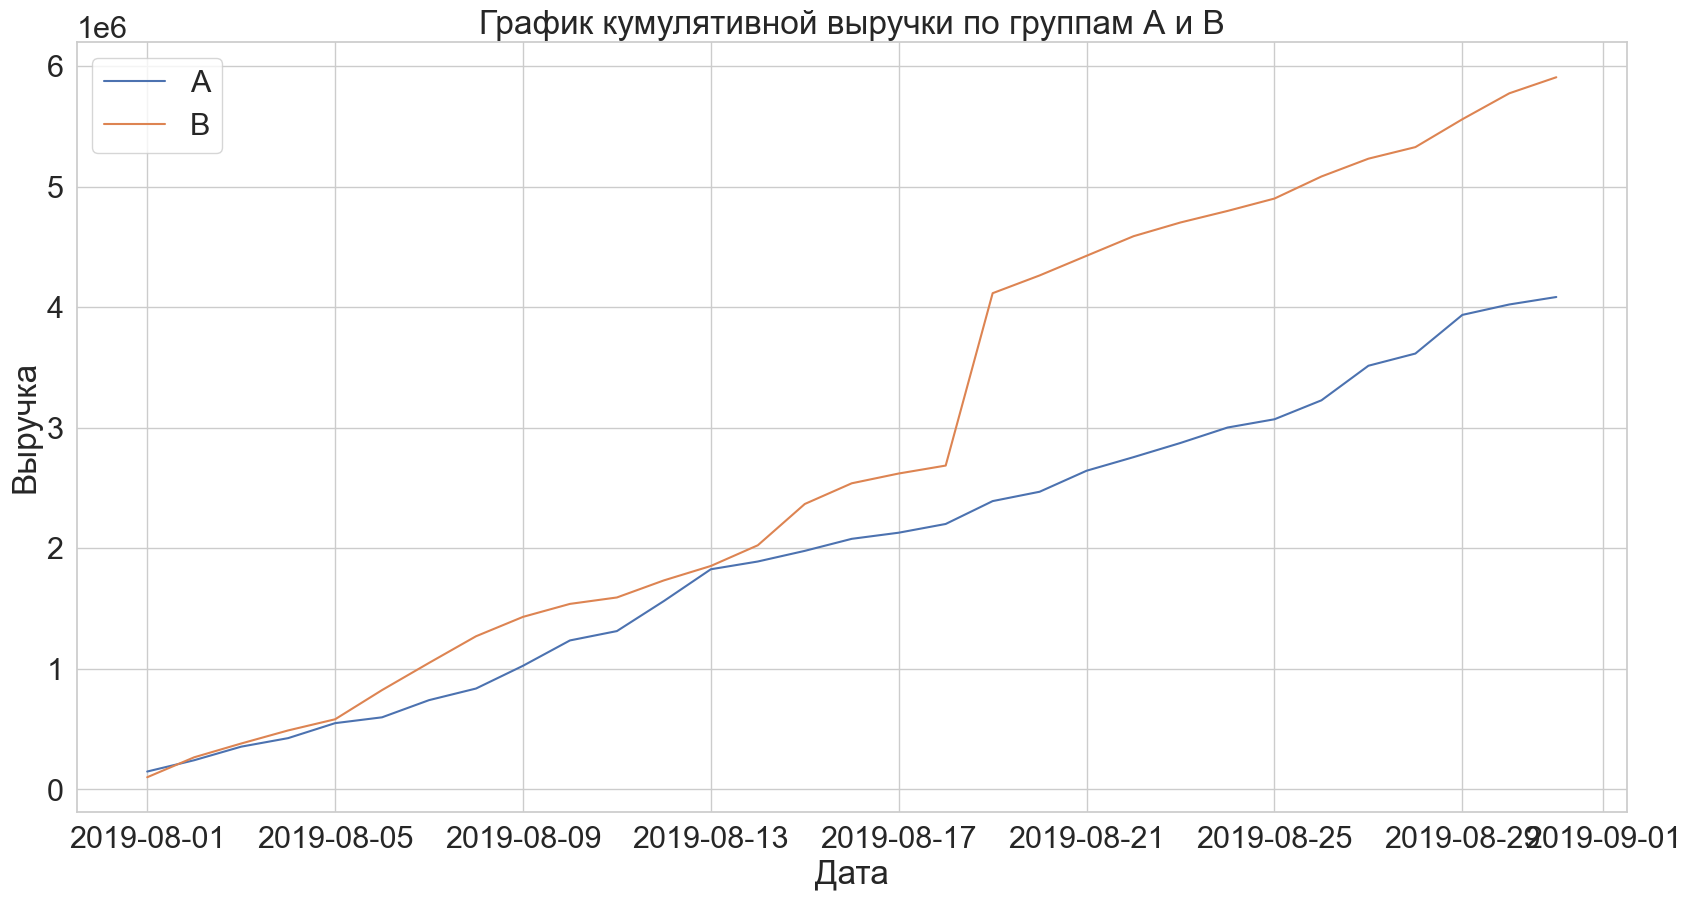

In [17]:
sns.set(font_scale=2, style='whitegrid', rc={'figure.figsize':(20,10)})

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам А и В')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend()
plt.show()

По графику мы видим, что в обеих группах выручка стабильно растет на протяжении всего периода. В начале теста обе группы показывали примерно одинаковые результаты, но в группе В 18.08 произошел резкий скачок  выручки. Причиной мог стать аномально дорогой заказ или большое количество заказов в этой группе в тот день. Дальше графики продалжают увеличиваться равномерно.

### График кумулятивного среднего чека по группам

Для того, чтобы найти средний чек, необходимо разделить выручку на количество заказов. Построим график.

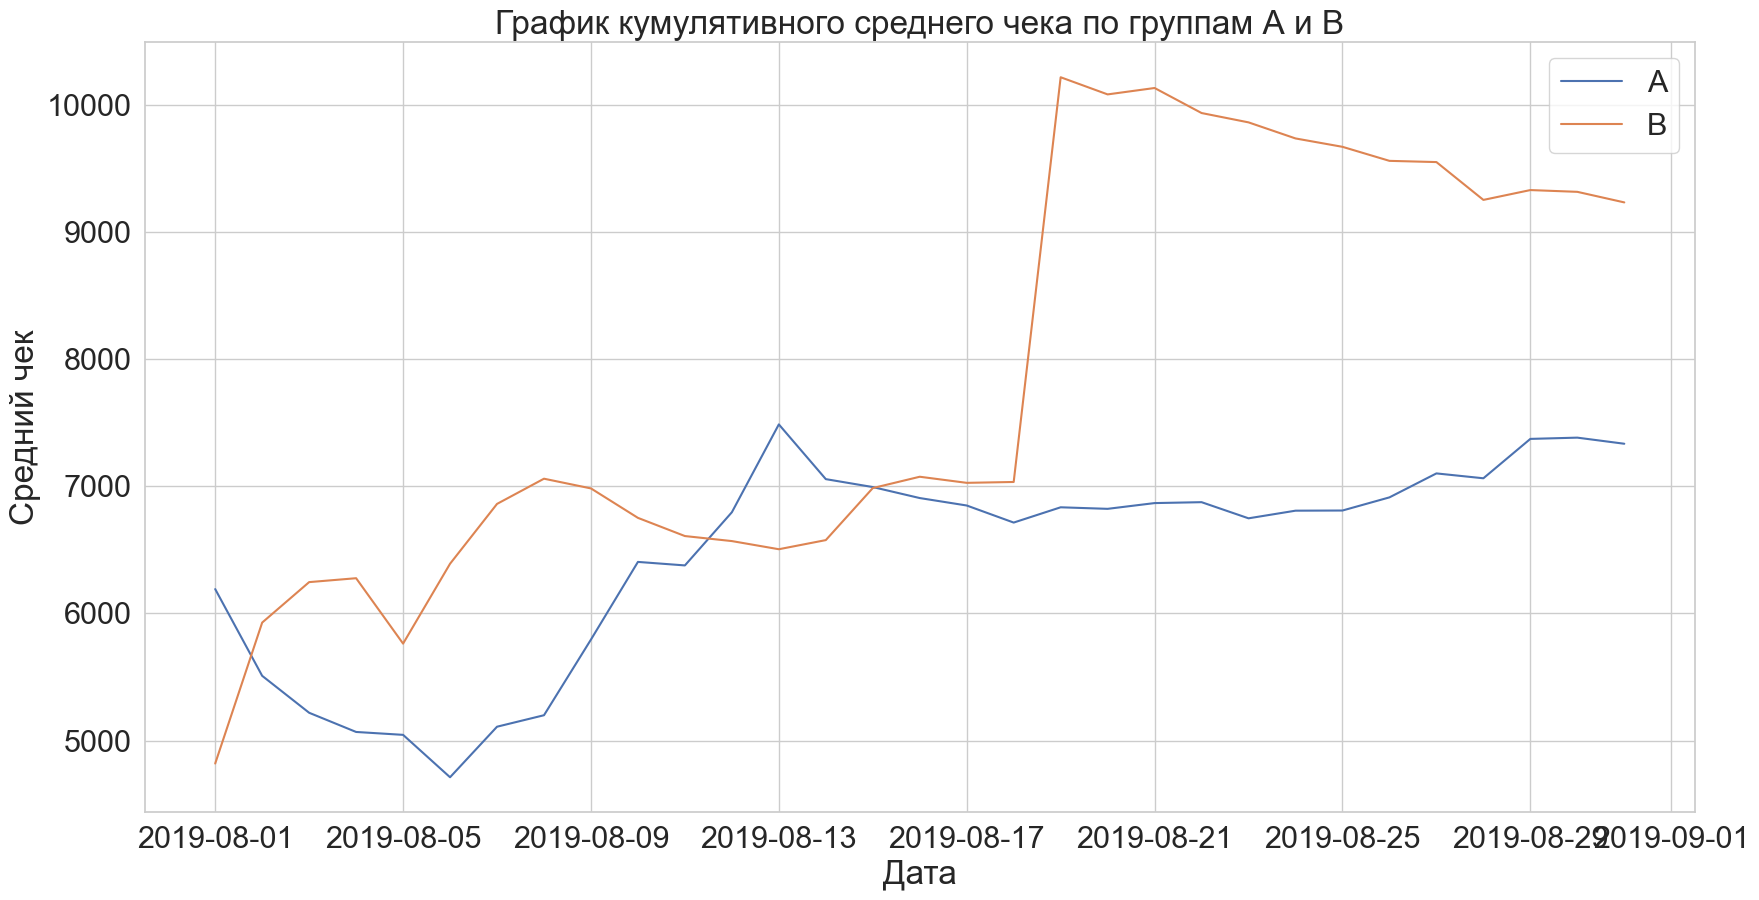

In [18]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам А и В')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend()
plt.show()

График ведет себя нестабильно большую часть теста и стабилизируется только к концу. На данном графике, как и на предыдущем, можно увидеть резкий подъем в группе В. Поскольку это график среднего чека, можно отмести предположение о том, что всплеск был вызван большим количеством заказом. Скорее всего, причиной стал аномально дорогой заказ.

### График относительного изменения кумулятивного среднего чека группы B к группе A

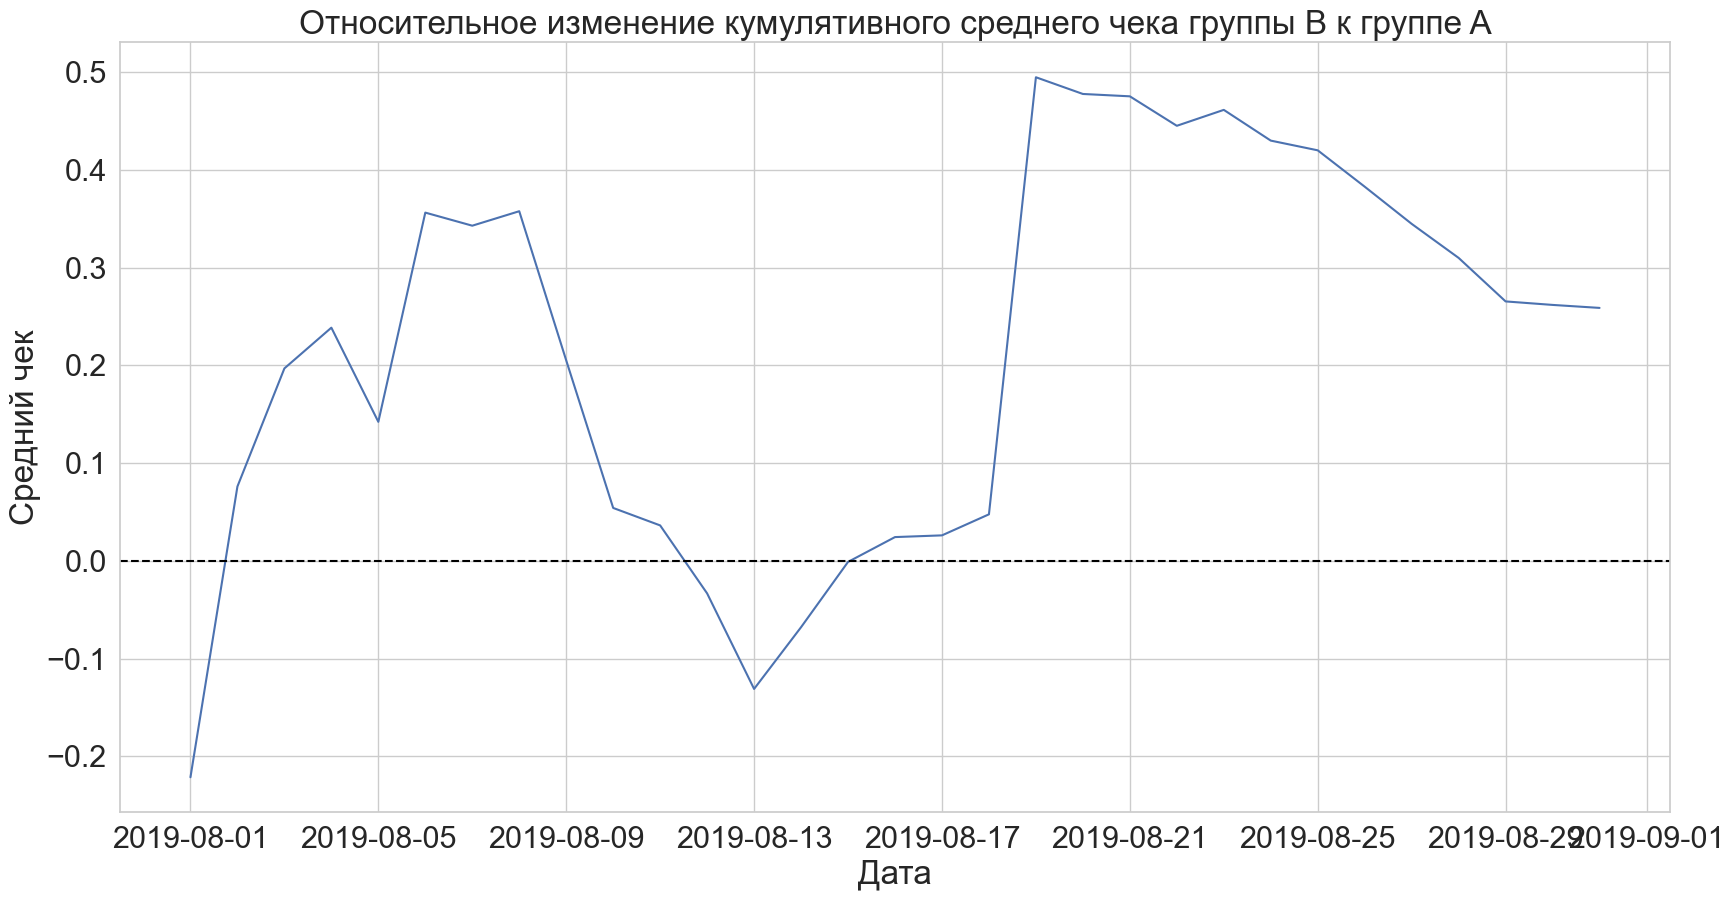

In [19]:
mergedCumulativeRevenue = cumulativeRevenueA.\
merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeRevenue['date'], \
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/\
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.show()

В начале теста средний чек группы В был выше чека группы А, затем 13.08 данные просели в сторону группы А. 18.08 произошел ранее обнаруженный нами аномальный заказ в группе В, после которого показатели стали стабилизироваться.

### График кумулятивного среднего количества заказов на посетителя по группам

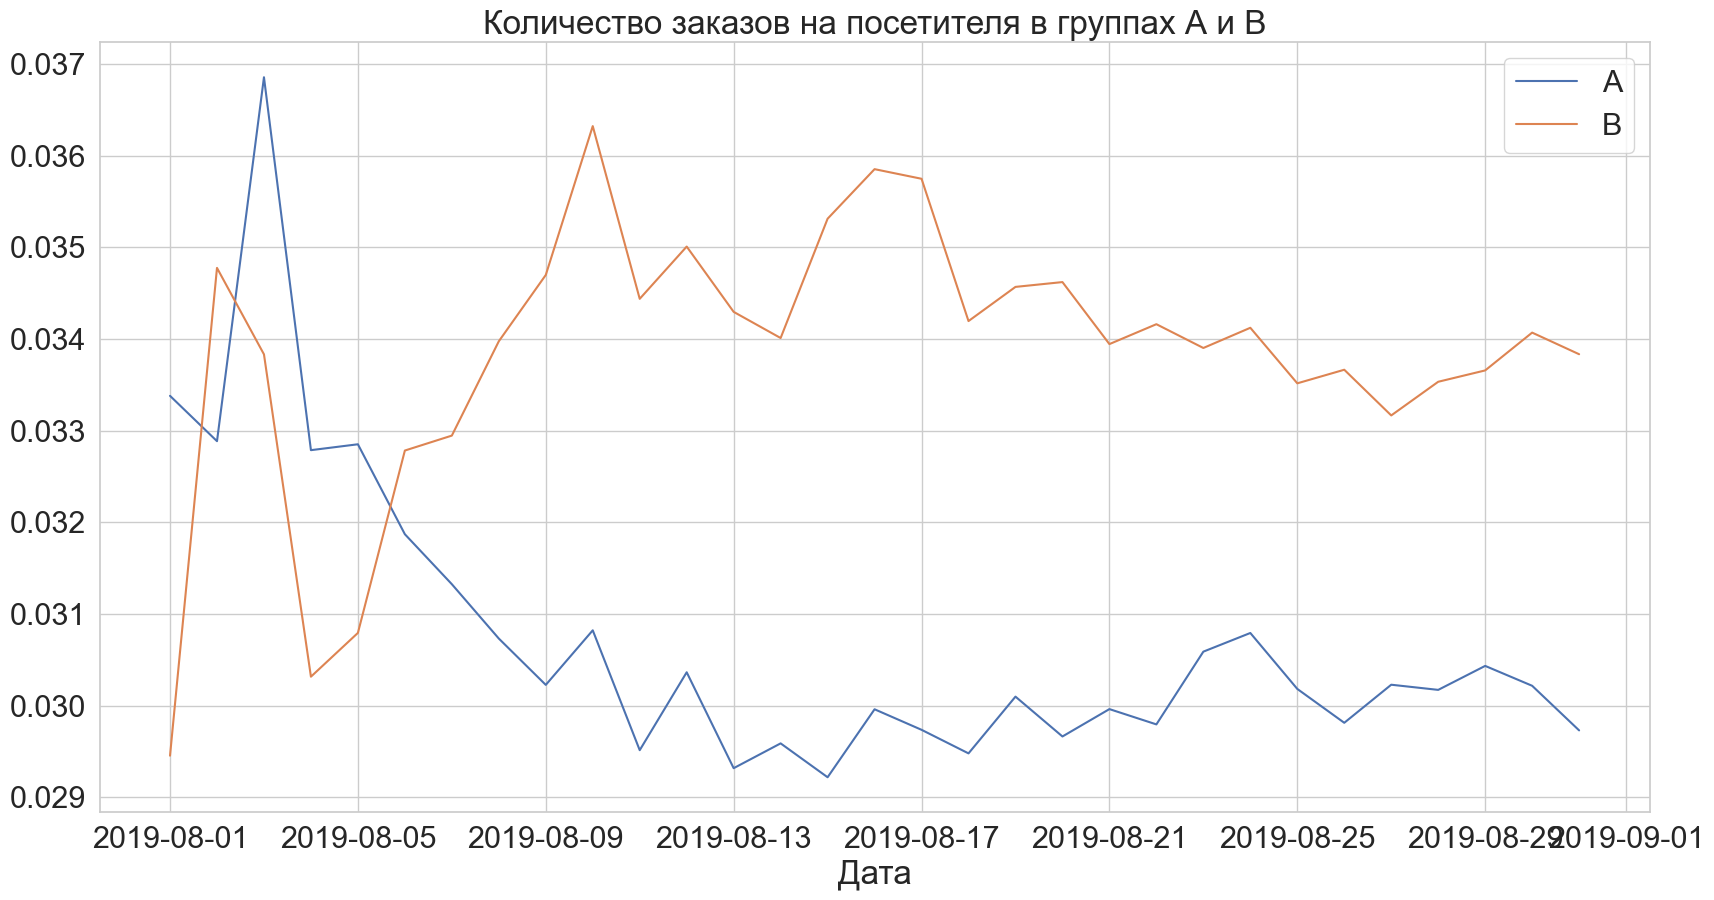

In [20]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('Количество заказов на посетителя в группах А и В')
plt.xlabel('Дата')
plt.show()

В начале теста данные колебались и вели себя нестабильно, но к середине теста данные стабилизировались в обеих группах.
В группе В количество заказов на человека превышает количество заказов в группе А.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

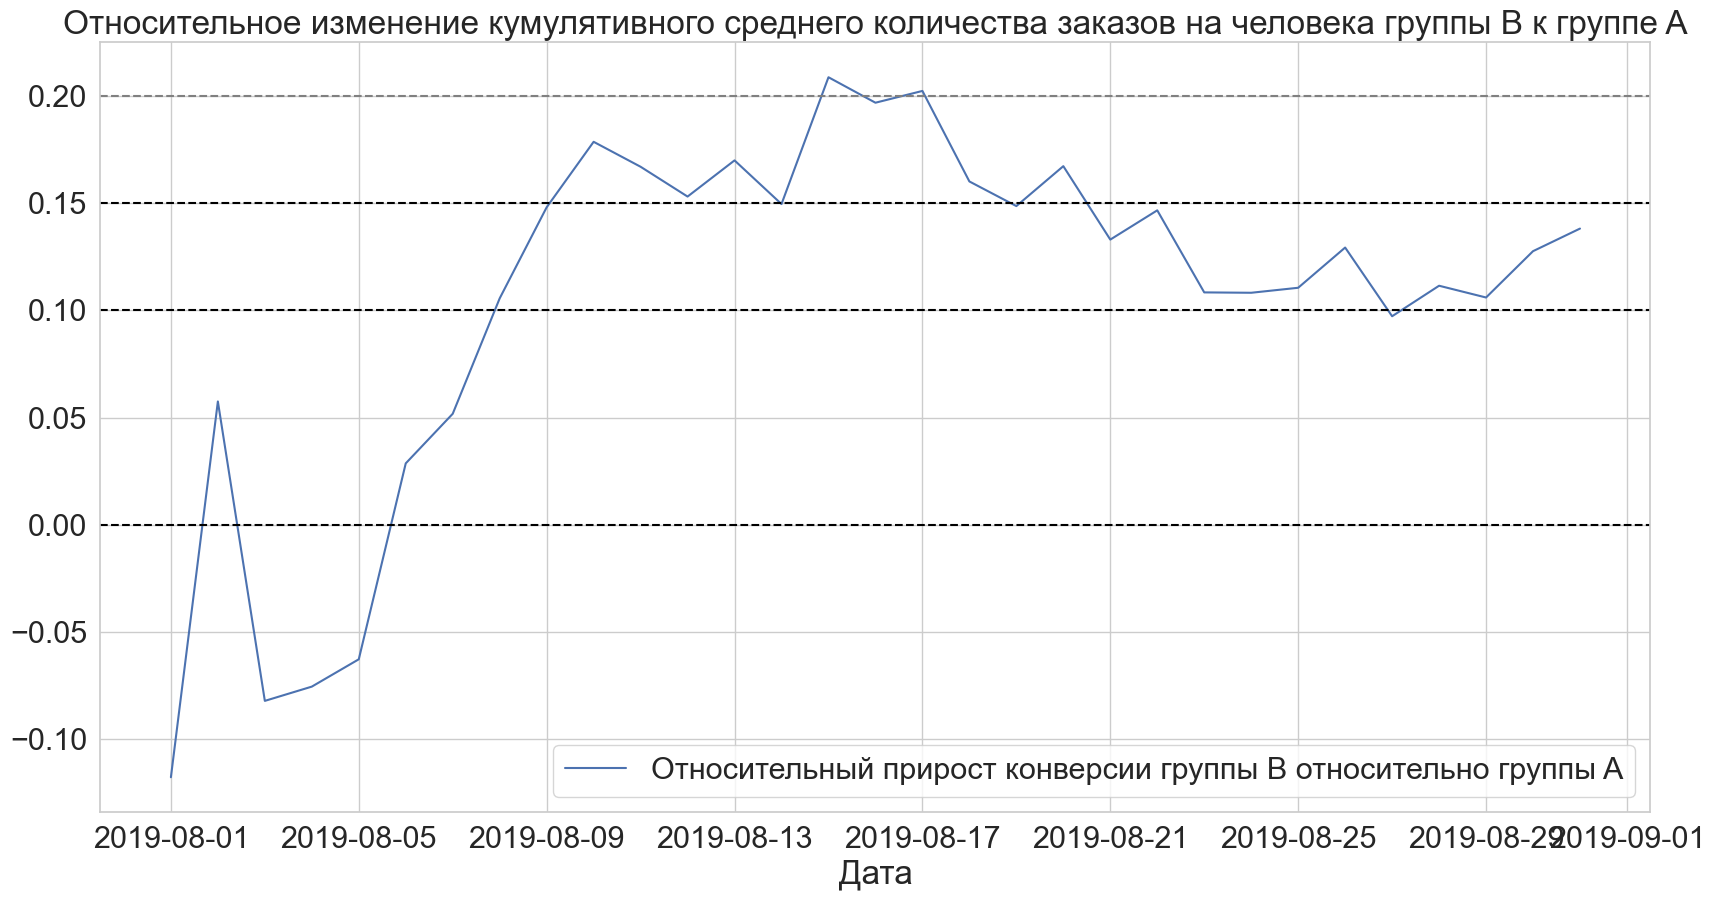

In [21]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]. \
merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/ \
         mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.title('Относительное изменение кумулятивного среднего количества заказов на человека группы B к группе A')
plt.xlabel('Дата')


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='black', linestyle='--')
plt.axhline(y=0.15, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.show()

В самом начале группа В проигрывала группе А, однако с 06.08 среднее количество заказов в группе В начало расти и под конец зафиксировалось в отметке около 13% прироста относительно группы А.

### Точечный график количества заказов по пользователям

Для начала нужно создать таблицу с уникальным ID человека и количеством его заказов.

In [22]:
ordersByVisitors = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByVisitors.columns = ['visitorId', 'orders']

ordersByVisitors.sort_values(by='orders', ascending=False).head(5)

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


Таблица готова, можно строить график.

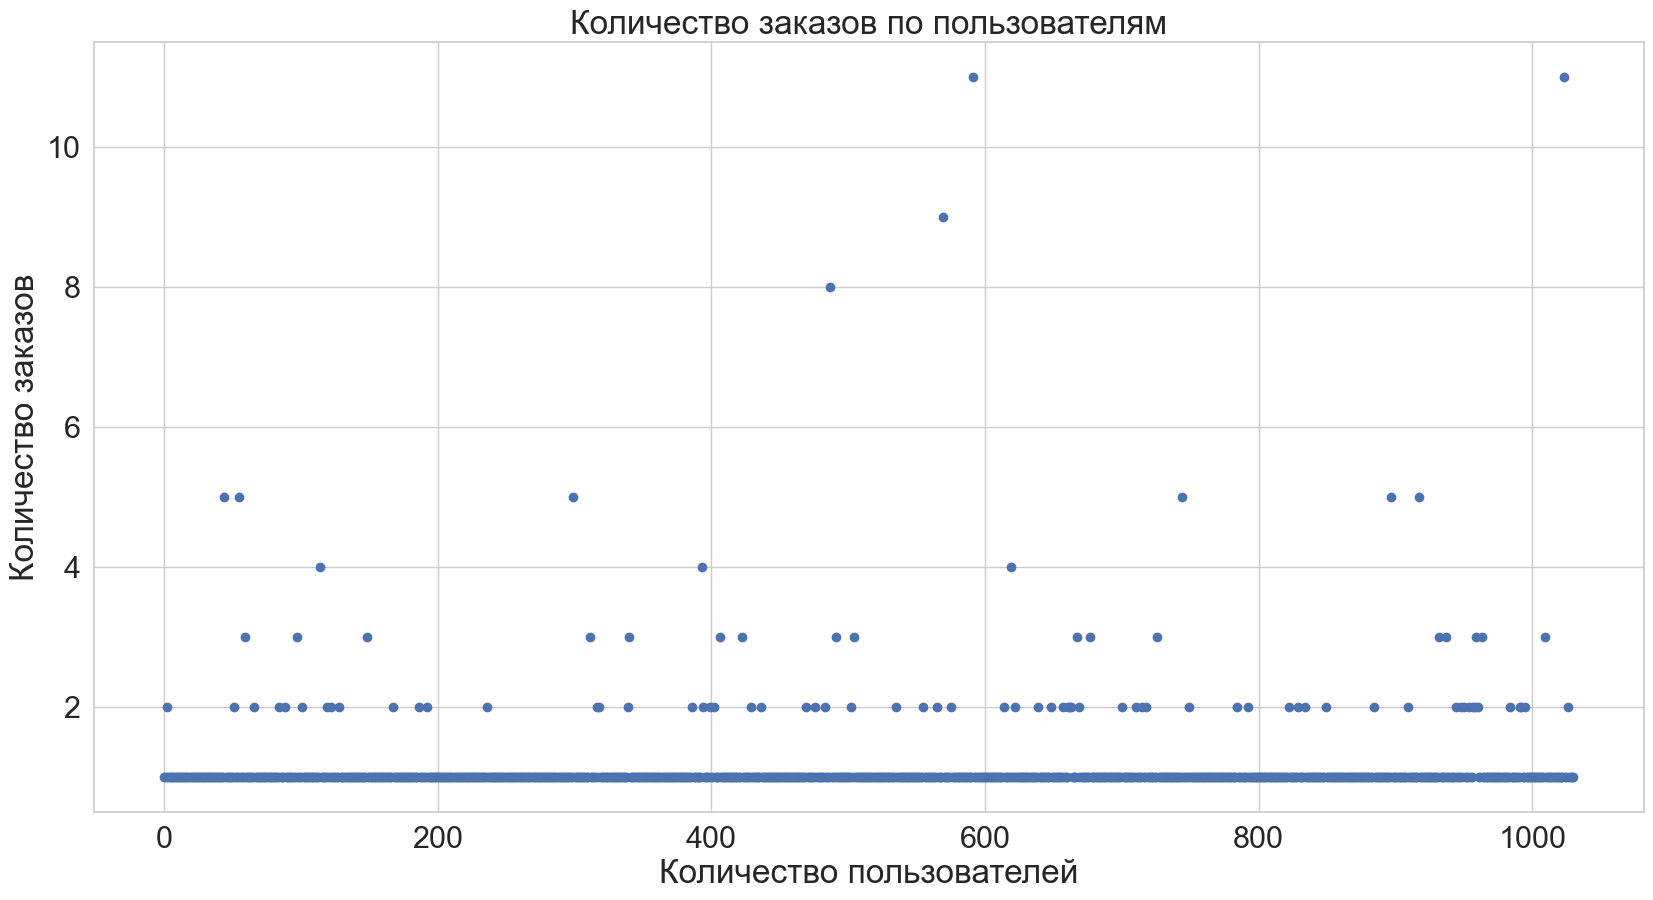

In [23]:
x_values = pd.Series(range(0, len(ordersByVisitors)))

plt.scatter(x_values, ordersByVisitors['orders']) 
plt.title('Количество заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.show()

На графике видно, что у основной массы пользователей по 1 заказу. Однако, есть доля пользователей с 2-3 заказами, нужно выяснить насколько большая эта доля, чтобы понять, можно ли их считать аномальными. Пользователи с 4 и более заказами абсолютно точно сочтутся за аномалии.

### 95-й и 99-й перцентили количества заказов на пользователя

In [24]:
np.percentile(ordersByVisitors['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершали больше 2-х заказов, и не более 1% больше 4-х. Разумно выбрать 2 заказа на человека как верхнюю границу для определения аномальных пользователей. Далее удалим аномалии из данных.

### Точечный график стоимостей заказов

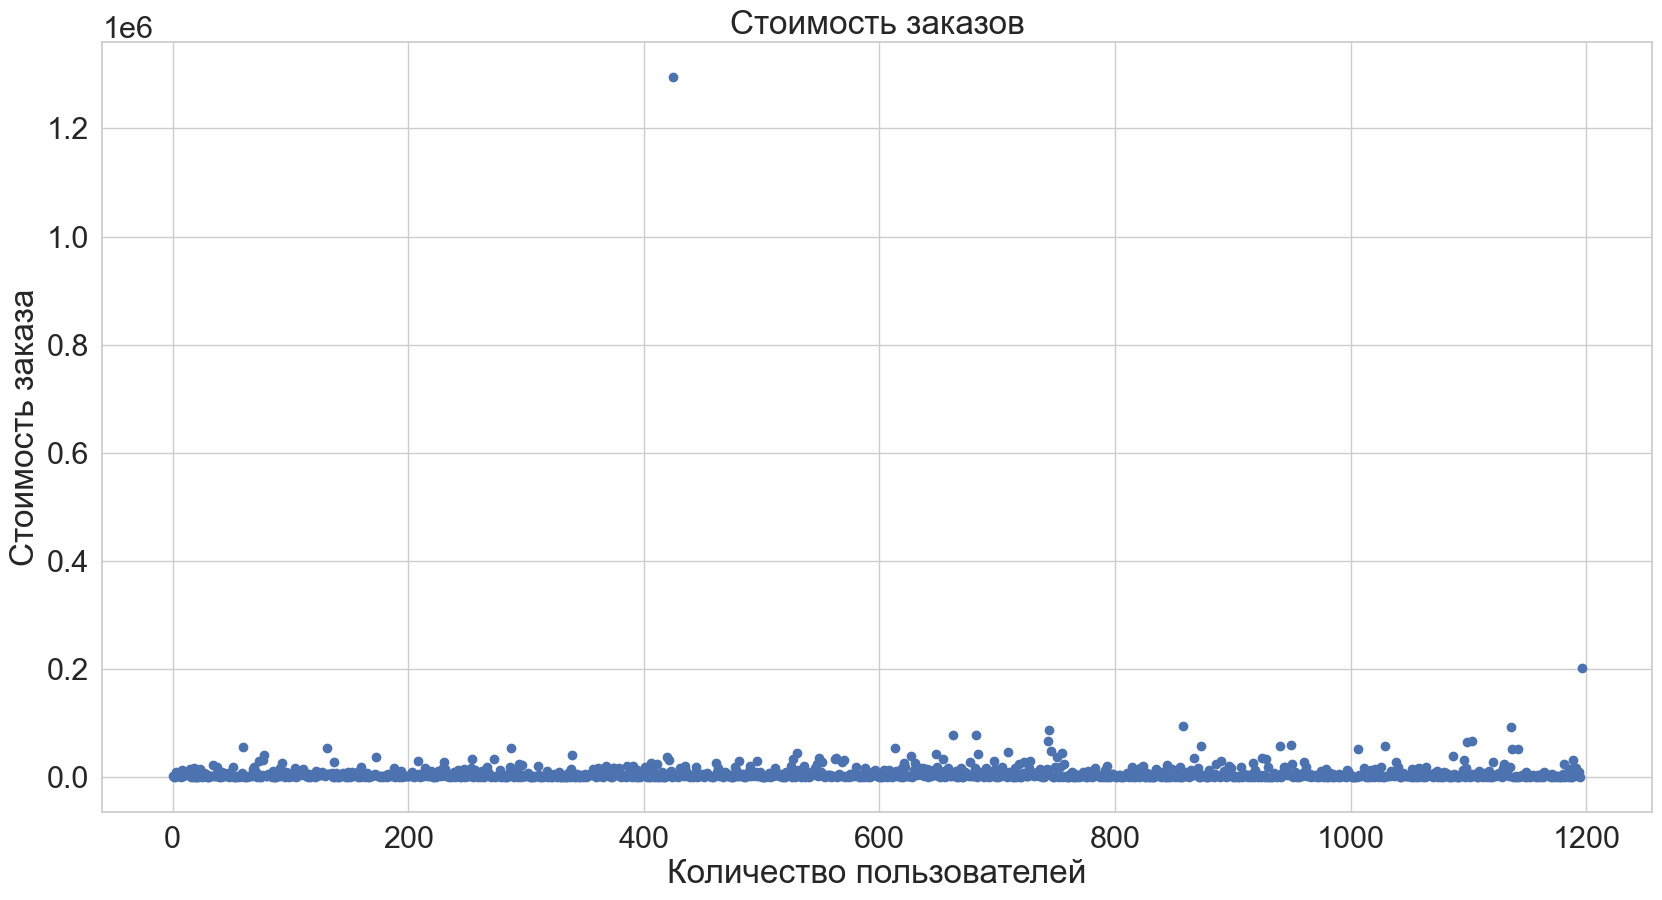

In [25]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

plt.title('Стоимость заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказа')
plt.show()

Большинство заказов сливаются в одну линию и трудно определить какую стоимость заказа можно считать аномальной. На графике также видно несколько отделившихся от общей массы точек, совершенно точно аномальных заказов, но их не так много, посмотрим на данные в перцентилях.

### 95-й и 99-й перцентили стоимости заказов

In [26]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Итак, не более 5% пользователей совершали заказ на сумму более 28000, и не более 1% на сумму 58233. Верхним значением для определения стоимости заказов выберем границу в 28000.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы:
* Н0: Среднее количество заказов на посетителя между группами одинаковое
* Н1: Среднее количество заказов на посетителя между группами разное

Зададим критический уровень статистической значимости в 5%:
 * alpha = 0.05
 
В данной работе для проверки гипотез будем использовать метод Уилкоксона-Манна-Уитни.

Для начала нужно собрать все данные, необходимые для расчета статистической значимости, в одну таблицу.

In [27]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Таблица готова. 

Пропишем обозначения названий столбцов:
* `date` — дата;
* `ordersPerDateA` — количество заказов в выбранную дату в группе A;
* `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
* `ordersPerDateB` — количество заказов в выбранную дату в группе B;
* `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
* `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
* `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
* `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
* `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
* `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
* `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
* `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
* `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

Далее создадим отдельные переменные для А и В групп для расчета статистической значимости

In [28]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

alpha = 0.05

results = stats.mannwhitneyu(sampleA, sampleB)[1]

print('p-значение:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

if (results < alpha):
    print('Отвергаем нулевую гипотезу, разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


print('Относительный выигрыш группы В равен', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


p-значение: 0.017
Отвергаем нулевую гипотезу, разница статистически значима
Относительный выигрыш группы В равен 0.138


P-значение оказалось ниже критического уровня статистической значимости в 0.05, а значит нулевую гипотезу о том, что разницы между средним количеством заказов на посетителя в группах нет, отвергаем. Среднее количество заказов на человека в группе В выше на 13.8%, чем в группе А.

### Статистическя значимость различий в среднем чеке заказа между группами по «сырым» данным

Теперь проверим статистическую значимость различий в среднем чеке между сегментами.

Сформулируем гипотезы:
* Н0: Различий в среднем чеке между группами нет
* Н1: Различия в среднем чеке между группами есть

In [29]:
results = (stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
                                              orders[orders['group']=='B']['revenue'])[1])

print('p-значение:', '{0:.3f}'.format(results))

if (results < alpha):
    print('Отвергаем нулевую гипотезу, разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Относительный выигрыш группы В равен','{0:.3f}'.format(orders[orders['group']=='B']['revenue']. \
                                                              mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-значение: 0.729
Не получилось отвергнуть нулевую гипотезу
Относительный выигрыш группы В равен 0.259


P-значение оказалось выше критического уровня, поэтому нет оснований отвергать гипотезу, хотя средний чек в группе В выше на 25,9% среднего чека в группе А.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Сперва очистим имеющиеся данные от аномалий.

Ранее, при расчете перцентилей о среднем количестве заказов на посетителя, был выбран верхний порог аномалии в 95%, чему равнялось 2 заказа на человека. Примем за аномалии пользователей, совершивших 3 и более заказов. 

При расчете аномалий о сумме заказала также был выбран порог в 95%, чему равнялось 28000.

Таким образом мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. 

Посчитаем сколько всего аномальных пользователей было в тесте:

In [30]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
74


Получаем 111 пользователей. Далее узнаем, как их действия повлияли на результаты теста.

In [31]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

print('p-значение:', '{0:.3f}'.format(results))

if (results < alpha):
    print('Отвергаем нулевую гипотезу, разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Относительный выигрыш группы В равен','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-значение: 0.013
Отвергаем нулевую гипотезу, разница статистически значима
Относительный выигрыш группы В равен 0.173


Результат анализа очищенных данных о среднем количеством заказов на посетителя практически не отличается от предыдущего. Так же, как и в прошлый раз, отвергаем нулевую гипотезу. Среднее количество заказов на человека в группе В повысилось на 16.8% относительно группы А.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Результаты по среднему количеству заказов практически не изменились. Посмотрим, произошло ли что-нибудь с результатами по среднему чеку.

In [32]:
results = stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', \
            np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId']. \
            isin(abnormalUsers)),)]['revenue'],)[1]

print('p-значение:', '{0:.3f}'.format(results))

if (results < alpha):
    print('Отвергаем нулевую гипотезу, разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Относительный проигрыш группы В равен', "{0:.3f}".format(orders[np.logical_and(
            orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean()
            / orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitorId'].isin(abnormalUsers)),)
            ]['revenue'].mean() - 1))

p-значение: 0.738
Не получилось отвергнуть нулевую гипотезу
Относительный проигрыш группы В равен -0.020


P-значение также практически не изменилось, оснований отвергать нулевую гипотезу у нас нет, однако по "сырым" данным средний чек в группе В был на 25,9% больше среднего чека группы А, по новым, "очищенным" данным, средний чек группы В стал на 0.6% меньше среднего чека группы А, что в рамках теста незначительно. Вероятно, это произошло после избавления от аномально дорогих заказов, которые были обнаружены в группе В еще на графиках.

[Начало страницы](#Анализ-гипотез-для-увеличения-выручки-интернет-магазина.-А/В-тестирование)

## Вывод

**По итогу проделанной работы можно сформулировать несколько выводов:**
   * Присутствует статистически значимое различие по среднему количеству заказов на пользователя между группами как по "сырым", так и по "очищенным" данным;
   * У группы В среднее количество заказов на человека больше на 13-16% относительно группы А;
   * Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
   * Преимущетсво группы В по среднему чеку было вызвано только из-за аномально дорогого заказа, после фильтрации данных средний чек группы А оказался на 0.6% выше относительно группы В.
   
Исходя из данных выводов, было принято решение остановить тест и признать его успешным. Группа В имеет преимущество по количеству заказов на человека, но касательно среднего чека, преимущетсва нет ни у одной из групп.

[Начало страницы](#Анализ-гипотез-для-увеличения-выручки-интернет-магазина.-А/В-тестирование)